# What is `Sparse3D`?

`Sparse3D` is a class designed to work with images made up of small, dense regions. Really, this is designed for astronomy images, but there might be other use cases. 

Here we'll talk a lot about *sparse* and *dense* data. Sparse just means "mostly containing zeros", and dense means "mostly containing non-zero values".

## What are we trying to achieve in astronomy?

Astronomy images tend to be large and sparse; they usually do not have a lot of stars in them. In addition, there are usually many, small, dense regions where there are stars. We frequently want to *model* these images.

Let's imagine we have an astronomy image that looks like this; it is a mostly sparse image, with two stars in it. The stars create dense regions (i.e. valued pixels), I've labeled the regions A and B.

```

        +-------------------------------------+
        |                                     |
        |                                     |
        |                                     |
        |   +-----+        +-----+            |
        |   |     |        |     |            |
        |   |  A  |        |  B  |            |
        |   |     |        |     |            |
        |   +-----+        +-----+            |
        |                                     |
        |                                     |
        |                                     |
        |                                     |
        |                                     |
        |                                     |
        +-------------------------------------+
```

If we wanted a model for this image, we could build a PSF model for the stars, and then evaluate it across every part of the image. This is tractable for small images, and few stars, but quickly becomes expensive. 

The above image might be easy to model if we cut it into pieces, but what happens when stars overlap

```
        +-------------------------------------+
        |                                     |
        |                                     |
        |                                     |
        |   +-----+        +-----+            |
        |   |     |        |     |            |
        |   |  A  |        |  B  |            |
        |   |     |        +-----+            |
        |   +-----+        +-----+            |
        |                  |  C  |            |
        |   +-----+        |     |            |
        |   |     |        +-----+            |
        |   |  D  |                           |
        |   |     |                           |
        |   +-----+                           |
        |                                     |
        +-------------------------------------+
```

Now to model the image we will have to model the B and C regions **simultaneously**, because they overlap.

If we want to do this we're going to need to evaluate the model for regions A, B, C, D and calculate the best fitting **linear sum** of these regions. 

```
                +-------------------------------------+
               /|                                     /|
              / |                                    / |
             /  +-----+        +-----+              /  |
            /   |     |        |     |             /   |
           /    |  A  |        |  B  |            /    |
          /     |     |        |     |           /     |
         /      +-----+        +-----+          /      |
        +-------------------------------------+/       |
        |                                     |        |
        |                  +-----+            |        |
        |                  |     |            |        |
        |                  |  C  |            |        |
        |   +-----+        |     |            |        |
        |   |     |        +-----+            |        |
        |   |  D  |                           |        |
        |   |     |                           |       / 
        |   +-----+                           |      /
        |                                     |     /
        |                                     |    /
        |                                     |   /
        +-------------------------------------+ 
```

This might look something like the cube above. This is an even sparser dataset than the image, with each layer of the cube containing values only in **one** of the dense regions. 

If we dot this cube with a set of weights $[A_w, B_w, C_w, D_w]$ we will get an image back, with all the regions multiplied by a value and added.

Creating this cube is intractable in astronomy if we have to keep track of all the zeros in memory. We would like to use the `sparse` library from `scipy`, but those arrays will not let us hold cubes. This is where `Sparse3D` comes in. `Sparse3D` will let you hold and work with this data, so that you can quickly compute your astronomy models.

## Simple Example

Below I show an example where we set up a 512 x 512 image, with 500 sources in it. I randomly distribute the sources. 

In [1]:
from sparse3d import Sparse3D
import numpy as np
import matplotlib.pyplot as plt

imshape = (512, 512)
nsources = 500
source_row, source_col = np.random.uniform(0, 512, size=(nsources, 2)).T

# These are the row and column positions of all the images
R, C = np.mgrid[:20, :20] - 10
R, C = R[:, :, None], C[:, :, None]

To show an example, I am going to create some data which is just ones. I will make a new matrix, and then I will pass in the row and column positions for the data.

In [2]:
data = np.ones((20, 20, nsources))
A = Sparse3D(data=data, row=R + source_row.astype(int), col=C + source_col.astype(int), imshape=imshape)

In [3]:
A

<(512, 512, 500) Sparse3D array of type float64>

Note that even though I passed in data with shape (20, 20, 500), my matrix is now shape (512, 512, 500), the size of the large sparse image.

Let's look at the first image in this cube. To turn this into a valued cube we'll dot it with the value 1.

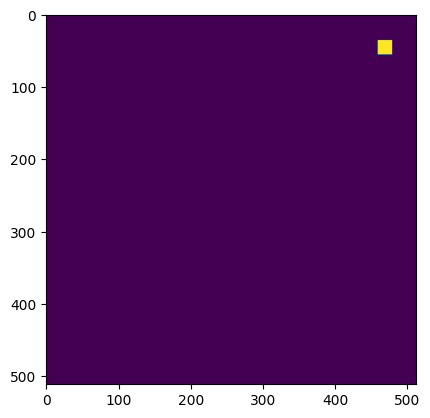

In [13]:
plt.imshow(A[:, :, 0].dot(1))

This slice of the cube contains just one dense region, as we expect. That dense region is 20 x 20 pixels. 

If we dot the entire cube with 500 ones, we will multiply each frame by one, and then sum all the frames.

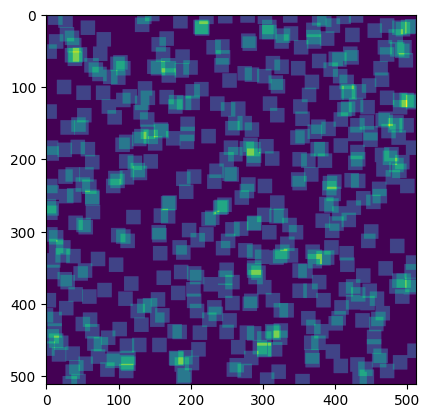

In [14]:
plt.imshow(A.dot(np.ones(500)))

This now has all the dense regions summed. You can see they are arranged around the image randomly. If we dot with different weights, we see each of the regions are weighted accordingly

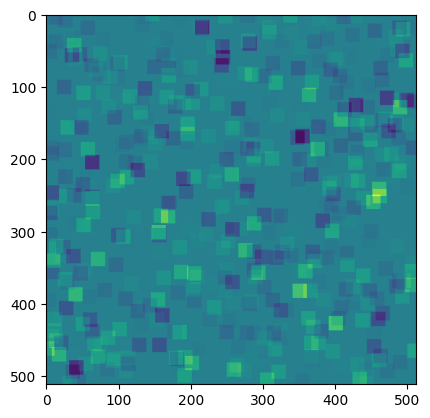

In [18]:
plt.imshow(A.dot(np.random.normal(size=500)))

Now you can now move onto the astronomy demonstration to see how this is useful for astronomy data.